To do:

- Finish with all English and Spanish models; add Pythia.
- For multilingual models:
   - Select only tokens that are also in BETO and BERT vocabulary. Rerun comparing those. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

import functools
import itertools
import os
import torch
import transformers
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from tqdm import tqdm


from scipy.spatial.distance import cosine
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from sklearn.metrics.pairwise import cosine_distances


sns.set(style='whitegrid',font_scale=1.2)

In [2]:
### Define useful custom functions to ...

### ... find the target tokens within tokenized sequence
def find_sublist_index(mylist, sublist):
    """Find the first occurence of sublist in list.
    Return the start and end indices of sublist in list"""

    for i in range(len(mylist)):
        if mylist[i] == sublist[0] and mylist[i:i+len(sublist)] == sublist:
            return i, i+len(sublist)
    return None

@functools.lru_cache(maxsize=None)  # This will cache results, handy later...


### ... grab the embeddings for your target tokens
def get_embedding(model, tokenizer, sentence, target, layer, device):
    """Get a token embedding for target in sentence"""
    
    # Tokenize sentence
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    
    # Tokenize target
    target_enc = tokenizer.encode(target, return_tensors="pt",
                                  add_special_tokens=False).to(device)
    
    # Get indices of target in input tokens
    target_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        target_enc[0].tolist()
    )

    # Run model
    with torch.no_grad():
        output = model(**inputs)
        hidden_states = output.hidden_states

    # Get layer
    selected_layer = hidden_states[layer][0]

    #grab just the embeddings for your target word's token(s)
    token_embeddings = selected_layer[target_inds[0]:target_inds[1]]

    #if a word is represented by >1 tokens, take mean
    #across the multiple tokens' embeddings
    embedding = torch.mean(token_embeddings, dim=0)
    
    return embedding

### ... grab the number of trainable parameters in the model

def count_parameters(model):
    """credit: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model"""
    
    total_params = 0
    for name, parameter in model.named_parameters():
        
        # if the param is not trainable, skip it
        if not parameter.requires_grad:
            continue
        
        # otherwise, count it towards your number of params
        params = parameter.numel()
        total_params += params
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [3]:
### Define the url paths to download your desired models
#.  from Hugging Face

# MODELS = ["bert-base-uncased",
#           "bert-base-cased",
#           "FacebookAI/xlm-roberta-base",
#           "albert/albert-base-v1",
#           "albert/albert-base-v2",
#           "albert/albert-large-v2",
#           "albert/albert-xlarge-v2",
#           "albert/albert-xxlarge-v2",
#           "FacebookAI/roberta-base",
#           "FacebookAI/roberta-large",
#           "distilbert/distilbert-base-uncased",
#           "google-bert/bert-base-multilingual-cased"]

### Define the url paths to download your desired models
#.  from Hugging Face

MODELS = ["dccuchile/bert-base-spanish-wwm-cased",
          "google-bert/bert-base-multilingual-cased",
          "FacebookAI/xlm-roberta-base",
          "dccuchile/albert-tiny-spanish",
          "dccuchile/albert-base-spanish",
          "dccuchile/albert-large-spanish",
          "dccuchile/albert-xlarge-spanish",
          "dccuchile/albert-xxlarge-spanish",
          "PlanTL-GOB-ES/roberta-base-bne",
          "PlanTL-GOB-ES/roberta-large-bne",
          "dccuchile/bert-base-spanish-wwm-uncased", 
          "dccuchile/distilbert-base-spanish-uncased",
         "dccuchile/patana-chilean-spanish-bert"]


In [37]:
mpath = MODELS[1]

In [38]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Load your model & tokenizer

model = transformers.AutoModel.from_pretrained(mpath,output_hidden_states=True)
model.to(device) # allocate model to desired device

tokenizer = transformers.AutoTokenizer.from_pretrained(mpath)  

In [39]:
# Specify the number of tokens you want to select
subset_size = 500  # For example, select 50 random tokens

# Get a list of all tokens
all_tokens = list(tokenizer.vocab.keys())

# Select a random subset of tokens
random_subset = random.sample(all_tokens, subset_size)

In [48]:
results = []
for mpath in MODELS:
    
    ### Load your model & tokenizer
    
    model = transformers.AutoModel.from_pretrained(mpath,output_hidden_states=True)
    model.to(device) # allocate model to desired device
    
    tokenizer = transformers.AutoTokenizer.from_pretrained(mpath)  

    # Specify the number of tokens you want to select
    subset_size = 500  # For example, select 50 random tokens
    
    # Get a list of all tokens
    all_tokens = list(tokenizer.vocab.keys())
    
    # Select a random subset of tokens
    random_subset = random.sample(all_tokens, subset_size)

    n_params = count_parameters(model)

    n_layers = model.config.num_hidden_layers
    
    for layer in range(n_layers+1): # `range` is non-inclusive for the last value of interval
        # Initialize a list to hold the embeddings
        embeddings = []
        
        # Loop through each token in the random subset
        for token in tqdm(random_subset):
            # Convert token to its corresponding ID
            token_id = tokenizer.convert_tokens_to_ids(token)
            
            # Get the token embedding (layer 0) by passing the token ID through the model's embedding layer
            with torch.no_grad():
                token_embedding = get_embedding(model, tokenizer, token, token, layer, device)
            
            # Store the embedding
            embeddings.append(token_embedding.squeeze().cpu().numpy())
    
        # Convert the list of embeddings to a NumPy array
        embeddings_array = np.array(embeddings)
        
        # Calculate cosine distances between all pairs in the random subset
        cosine_distances_matrix = cosine_distances(embeddings_array)
    
    
        # Mask the diagonal by setting it to `NaN` or simply remove those elements
        mask = np.eye(cosine_distances_matrix.shape[0], dtype=bool)
        masked_distances = np.ma.masked_array(cosine_distances_matrix, mask)
        
        # Calculate the mean of the non-diagonal elements
        mean_cosine_distance = masked_distances.mean()
    
    
        ## Do PCA on the matrix
        X_transformed = PCA(n_components=5).fit_transform(embeddings_array)
    
        # Calculate cosine distances between all pairs in the random subset
        cosine_distances_pca_matrix = cosine_distances(X_transformed)
    
        # Mask the diagonal by setting it to `NaN` or simply remove those elements
        mask = np.eye(cosine_distances_pca_matrix.shape[0], dtype=bool)
        masked_distances_pca = np.ma.masked_array(cosine_distances_pca_matrix, mask)
        
        # Calculate the mean of the non-diagonal elements
        mean_cosine_distance_pca = masked_distances_pca.mean()
    
        # Calculate the convex hull
        hull = ConvexHull(X_transformed)
    
        results.append({
            'layer': layer,
            'mean_cosine_distance': mean_cosine_distance,
            'mean_cosine_similarity': 1 - mean_cosine_distance,
            'mean_cosine_distance_pca': mean_cosine_distance_pca,
            'mean_cosine_similarity_pca': 1 - mean_cosine_distance_pca,
            'hull_volume': hull.volume,
            'hull_sa': hull.area,
            'model': mpath,
            'n_params': n_params
        })

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Trainable Params: 109850880


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Total Trainable Params: 177853440


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Total Trainable Params: 278043648


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Total Trainable Params: 5344136


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Total Trainable Params: 11811584


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Total Trainable Params: 17811968


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Total Trainable Params: 58852864


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [49]:
df_results = pd.DataFrame(results)
df_results.head(3)

,layer,mean_cosine_distance,mean_cosine_similarity,mean_cosine_distance_pca,mean_cosine_similarity_pca,hull_volume,hull_sa,model,n_params
0,0,0.824604,0.175396,0.970356,0.029644,14319.971310,17461.113311,dccuchile/bert-base-spanish-wwm-cased,109850880
1,1,0.753414,0.246586,0.978045,0.021955,26486.260486,27886.699766,dccuchile/bert-base-spanish-wwm-cased,109850880
2,2,0.604437,0.395563,0.982496,0.017504,20656.654449,23494.972733,dccuchile/bert-base-spanish-wwm-cased,109850880


/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/pyt

<Axes: xlabel='layer', ylabel='mean_cosine_similarity'>

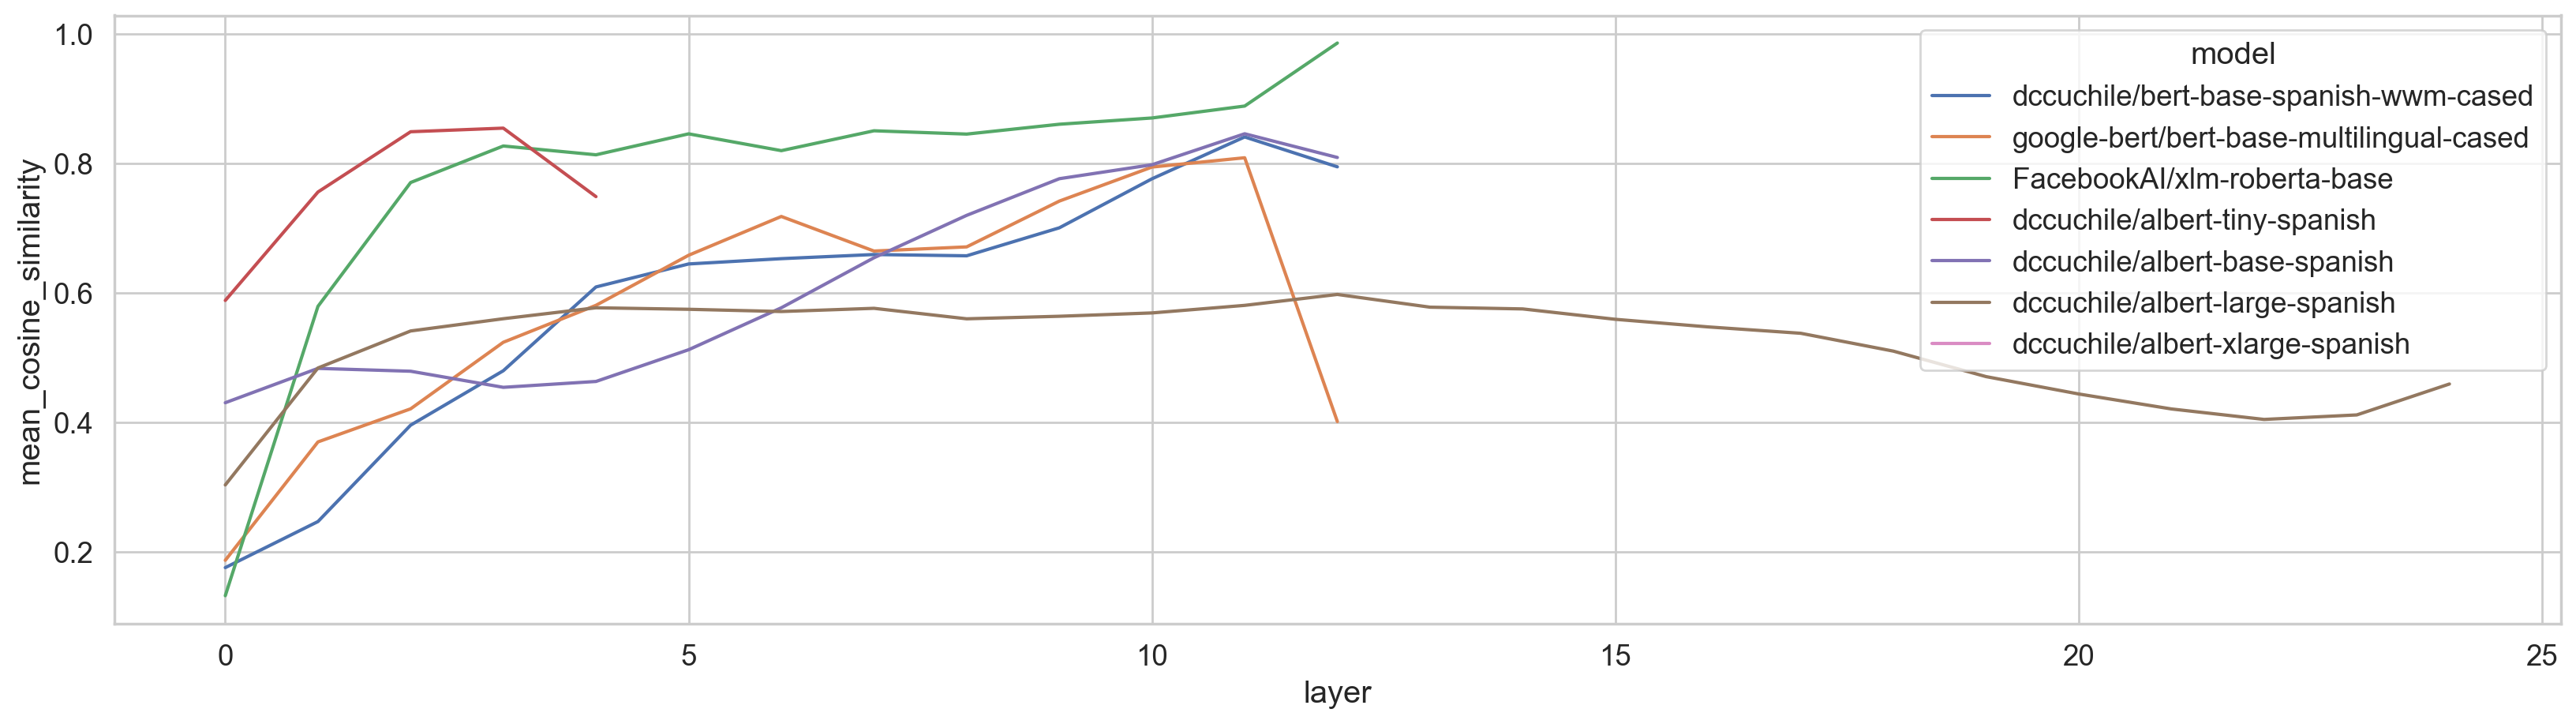

In [50]:
fig,ax = plt.subplots(figsize=(20,5))
sns.lineplot(data = df_results, x = "layer", y = "mean_cosine_similarity", hue = "model")

/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/python3.11/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/seantrott/anaconda3/lib/pyt

<Axes: xlabel='layer', ylabel='hull_volume'>

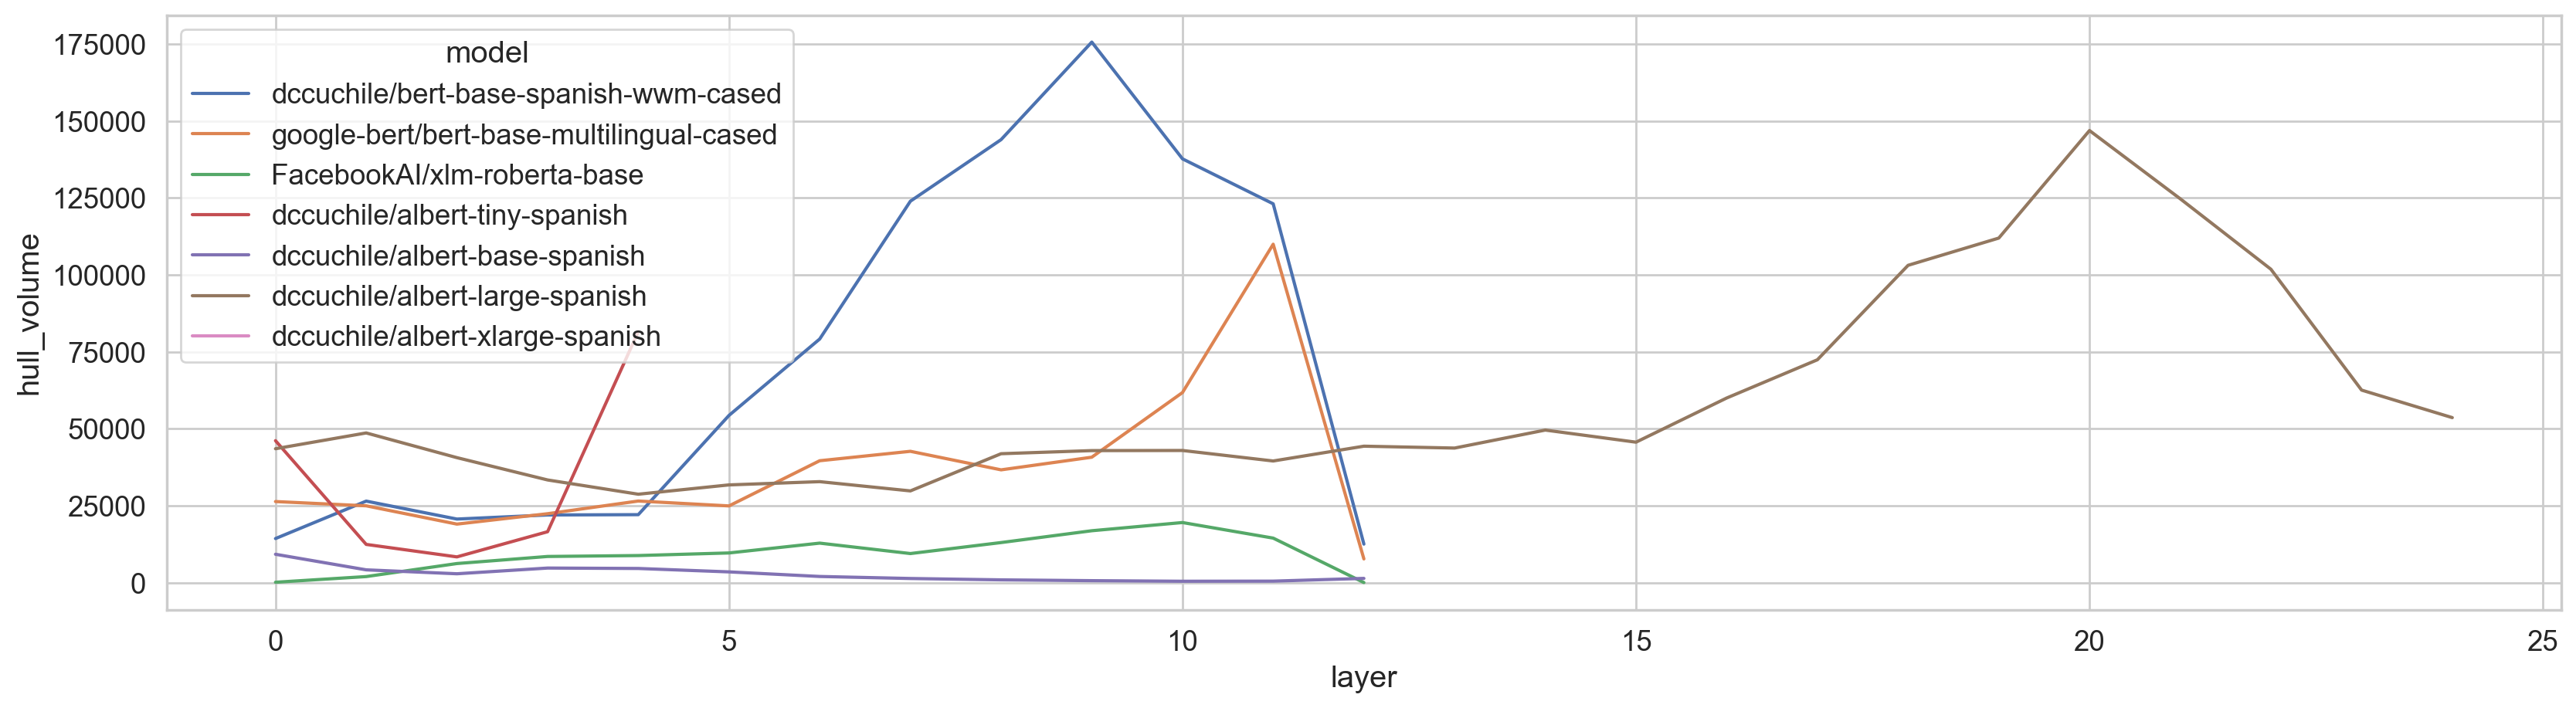

In [52]:
fig,ax = plt.subplots(figsize=(20,5))
sns.lineplot(data = df_results, x = "layer", y = "hull_volume", hue = "model")

In [22]:
# Calculate the convex hull
hull = ConvexHull(X_transformed)


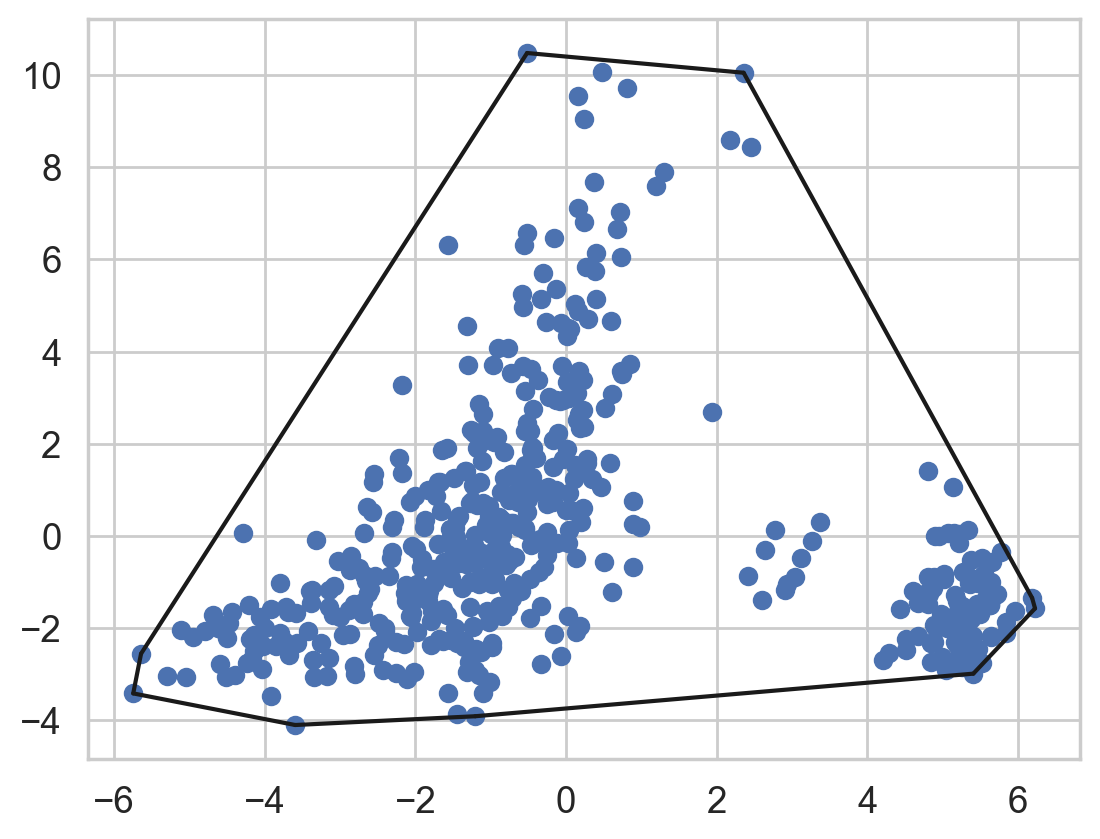

In [23]:
# Plot the points
plt.plot(X_transformed[:, 0], X_transformed[:, 1], 'o')

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(X_transformed[simplex, 0], X_transformed[simplex, 1], 'k-')